# Running first Tests with Parcels

## Setup

In [1]:
import xarray as xr
import cmocean as cmo

from datetime import datetime, timedelta

import numpy as np

import parcels

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from tqdm import tqdm

## Quick look at the model data

In [3]:
# Gridded example file from Claudia at 100m depth
#file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
#file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_withdepth_float.nc" #
file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc"
ds_model = xr.open_dataset(file)

In [5]:
file2 = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
ds_model2 = xr.open_dataset(file2)

### Convert time format in netCDF file

In [ ]:
import cftime
import numpy as np


ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded.nc")

# Define a reference date (can be 2000-01-01 or match the model start date)
ref_time = cftime.DatetimeNoLeap(2000, 1, 1)

# Use `.astype("O")` to safely loop over datetimes
time_vals = ds_model.time.values.astype("O")
converted_time = np.array([(t - ref_time).total_seconds() for t in time_vals])

# Replace the time variable
ds_model["time"] = ("time", converted_time)
ds_model["time"].attrs["units"] = "seconds since 2000-01-01 00:00:00"
ds_model["time"].attrs["calendar"] = "standard"  # instead of "noleap"
# Save to new NetCDF

ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc")

  0%|          | 0/8640000.0 [04:52<?, ?it/s]


In [28]:
import cftime
import numpy as np


ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_withdepth_float.nc")

# Define a reference date (can be 2000-01-01 or match the model start date)
ref_time = cftime.DatetimeNoLeap(2000, 1, 1)

# Use `.astype("O")` to safely loop over datetimes
time_vals = ds_model.time.values.astype("O")
converted_time = np.array([(t - ref_time).total_seconds() for t in time_vals])

# Replace the time variable
ds_model["time"] = ("time", converted_time)
ds_model["time"].attrs["units"] = "seconds since 2000-01-01 00:00:00"
ds_model["time"].attrs["calendar"] = "standard"  # instead of "noleap"
# Save to new NetCDF

ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_with-depth_converted-time.nc")

### Create dummy velocity field with constant velocity

In [51]:
ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc") # _withdepth
for time in tqdm(range(len(ds_model.time))):
    ds_model.u.values[time,:,:] = np.zeros((ds_model.lat.size, ds_model.lon.size)) # changed for depth
    ds_model.v.values[time,:,:] = np.ones((ds_model.lat.size, ds_model.lon.size)) * 0.2# changed for depth

ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_time_const-v0.2.nc")

100%|██████████| 365/365 [00:27<00:00, 13.38it/s] 


In [ ]:
ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_converted-time.nc") # _withdepth

# replace u and v fields with a constand field (of maybe a gradient increasing from west to east)
#ds_model = ds_model.transpose("time", "lon", "lat") # changed for depth


for time in range(len(ds_model.time)):
    ds_model.u.values[time,:,:] = np.ones((ds_model.lat.size, ds_model.lon.size)) * 0.4 # changed for depth
    ds_model.v.values[time,:,:] = np.zeros((ds_model.lat.size, ds_model.lon.size)) # changed for depth

ds_model = ds_model.transpose("time", "lon", "lat") # changed for depth

# Create dataset for gridded data
ds_final_ordered_repr = xr.Dataset(
    {
        "temp": (["time", "lon", "lat"], ds_model.temp.values),
        "salt": (["time", "lon", "lat"], ds_model.salt.values),
        "u": (["time", "lon", "lat"], ds_model.u.values),
        "v": (["time", "lon", "lat"], ds_model.v.values),
    },
    coords={
        "time": ds_model.time.values,
        "lon": (["lon"], ds_model.lon.values.squeeze()),
        "lat": (["lat"], ds_model.lat.values.squeeze()),
    },
)

ds_final_ordered_repr.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_time_const-v-0.4_transposed.nc")

### Create dummy velocity field with east west gradient

In [34]:
ds_model.transpose("time", "depth", "lat", "lon")

<xarray.Dataset> Size: 4GB
Dimensions:  (depth: 1, time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * depth    (depth) float32 4B 0.0
Data variables:
    temp     (time, depth, lat, lon) float32 964MB ...
    salt     (time, depth, lat, lon) float32 964MB ...
    u        (time, depth, lat, lon) float32 964MB nan 0.01576 ... -0.01223
    v        (time, depth, lat, lon) float32 964MB ...

100%|██████████| 365/365 [00:01<00:00, 251.63it/s]


In [38]:
ds_model.close()

In [41]:
ds_final_ordered_repr#.close()

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 365, lon: 800, lat: 825)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
Data variables:
    temp     (time, lon, lat) float64 2GB nan -1.731 -1.728 ... -1.841 -1.841
    salt     (time, lon, lat) float64 2GB nan 31.71 31.71 ... 33.6 33.59 33.59
    u        (time, lon, lat) float64 2GB 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    v        (time, lon, lat) float64 2GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [41]:
ds_model = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_with-depth_converted-time.nc") # _withdepth

# replace u and v fields with a constand field (of maybe a gradient increasing from west to east)
vmin, vmax = 0.1, 0.2
row_gradient_u = np.linspace(-vmin, -vmax, ds_model.u.shape[-1])
row_gradient_v = np.linspace(vmin, vmax, ds_model.u.shape[-1])
gradient_field_u = np.tile(row_gradient_u, (ds_model.u.shape[-2], 1))
gradient_field_v = np.tile(row_gradient_v, (ds_model.u.shape[-2], 1))

ds_model = ds_model.transpose("time", "depth", "lat", "lon") # changed for depth
for time in range(len(ds_model.time)):
    ds_model.u.values[time,0,:,:] = gradient_field_u # changed for depth
    ds_model.v.values[time,0,:,:] = gradient_field_v # changed for depth
ds_model.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_with-depth_converted-time_gradient-test.nc")

KeyboardInterrupt: 

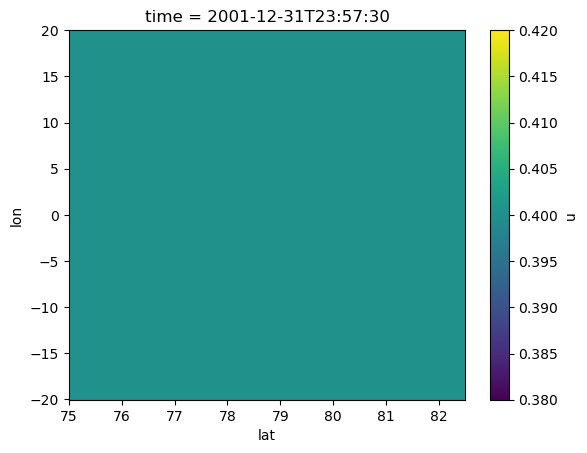

In [6]:
ds_model_dummy = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/Arc40-2002-gridded_0m_with-time_const-v-0.4.nc")
ds_model_dummy.u.isel(time=0).plot()

### Calculate Vorticity Offline

In [6]:
U = ds['uo']
V = ds['vo']

# Compute derivatives directly; xarray handles broadcasting if coords are properly defined
dVdx = V.differentiate('longitude')
dUdy = U.differentiate('latitude')

# Relative vorticity: dV/dx - dU/dy
vorticity = dVdx - dUdy
vorticity.name = "vorticity"

# Save to NetCDF
#vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

In [9]:
vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

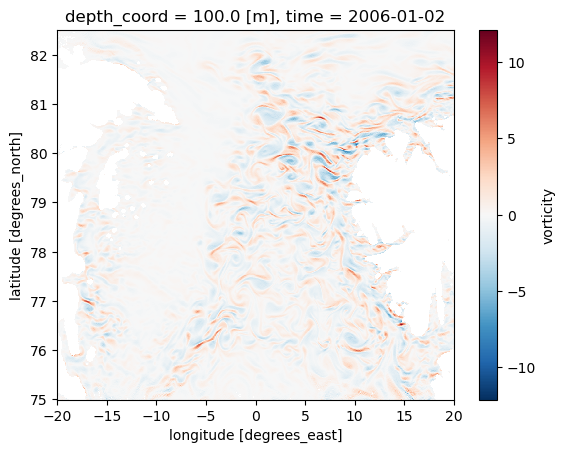

In [8]:
vorticity.isel(time=0).plot()

In [4]:
ds_vort = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")
ds_vort

<xarray.Dataset> Size: 8GB
Dimensions:      (latitude: 825, longitude: 800, depth_coord: 1, time: 1460)
Coordinates:
  * latitude     (latitude) float64 7kB 75.0 75.01 75.02 ... 82.48 82.49 82.5
  * longitude    (longitude) float64 6kB -20.0 -19.95 -19.9 ... 19.9 19.95 20.0
  * depth_coord  (depth_coord) float64 8B 100.0
  * time         (time) datetime64[ns] 12kB 2006-01-02 2006-01-03 ... 2010-01-01
Data variables:
    vorticity    (time, depth_coord, latitude, longitude) float64 8GB ...

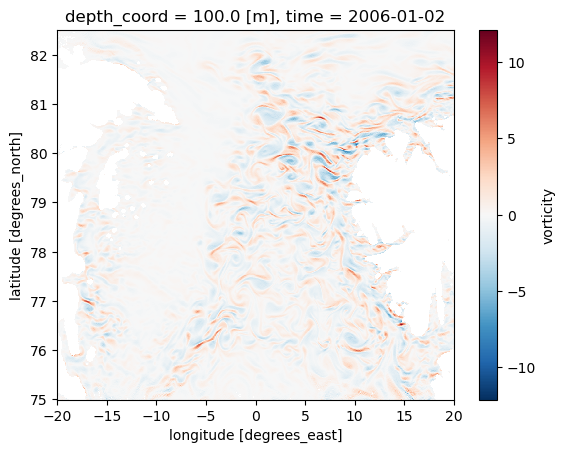

In [5]:
ds_vort.vorticity.isel(time=0).plot()

## Parcels Setup

In [20]:
#
#inpath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/"
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"
#file   = "Arc40.2002.oce.mean.sub_gridded.nc"#"
#file =  "Arc22.gridded_100m_oce_2006_2009_new.nc"
#file = "Arc40-2002-gridded_0m_time_const-v-0.4_transposed.nc" #"Arc40-2002-gridded_0m_converted-time.nc"#_gradient-test.nc"
file = "Arc40.2002.oce.mean.sub_gridded.nc" # Arc40-2002-gridded_0m_with-depth_converted-time.nc
#fname  = f"{inpath}/Arc40.2002.oce.mean.sub_gridde*.nc"
ds_model = xr.open_dataset(inpath + file)

outpath  = "/albedo/home/quraus001/FESOM-FS-subduction/outdata/"
outfname = "surface-test_data_gradient"
outfile  = f"{outpath}{outfname}.zarr"

In [11]:
ds_model

<xarray.Dataset> Size: 4GB
Dimensions:  (depth: 1, time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * depth    (depth) float32 4B 0.0
Data variables:
    temp     (depth, time, lat, lon) float32 964MB ...
    salt     (depth, time, lat, lon) float32 964MB ...
    u        (depth, time, lat, lon) float32 964MB ...
    v        (depth, time, lat, lon) float32 964MB ...

In [3]:
print(ds_model)
print(f"u velocity max: {ds_model.u.isel(time=0).max().values.item()}, min: {ds_model.u.isel(time=0).min().values.item()}, mean: {ds_model.u.isel(time=0).mean().values.item():.3f}")

<xarray.Dataset> Size: 4GB
Dimensions:  (depth: 1, time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * depth    (depth) float32 4B 0.0
Data variables:
    temp     (depth, time, lat, lon) float32 964MB ...
    salt     (depth, time, lat, lon) float32 964MB ...
    u        (depth, time, lat, lon) float32 964MB ...
    v        (depth, time, lat, lon) float32 964MB ...
u velocity max: 0.6573327779769897, min: -0.5122277736663818, mean: -0.035


In [21]:
filenames = {
    'U': inpath +file,
    'V': inpath +file,
    "T": inpath +file,
    "S": inpath +file,
    #"vorticity": "/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc",
}

variables = {
    'U': 'u',
    'V': 'v',
    "T": 'temp',
    "S": 'salt',
    #"vorticity": 'vorticity',
}

dimensions = {
    'time': 'time',
    'lon': 'lon',
    'lat': 'lat',
    #'depth': 'depth',
}

fieldset = parcels.FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    mesh='spherical',  # or flat
    indices={'depth': [0]},  # fixed 0m layer
    allow_time_extrapolation=True
)

In [22]:
print("U field lon range:", fieldset.U.lon[0], "to", fieldset.U.lon[-1])
print("U field lat range:", fieldset.U.lat[0], "to", fieldset.U.lat[-1])


U field lon range: -20.0 to 20.0
U field lat range: 75.0 to 82.5


In [23]:
fieldset.time_origin.time_origin

cftime.DatetimeNoLeap(2002, 1, 1, 23, 57, 30, 0, has_year_zero=True)

## Particle Setup

In [24]:
from parcels import AdvectionRK4 
from parcels import JITParticle, Variable

# STEP 1: Set up your particle release locations
n = 10                               # number of particles 
lons = np.linspace(0,11,n)#np.full(n, 3)                 
lats = np.full(n, 78.3)#np.linspace(78, 80, n)
depths = np.full(n, 0.0)           # all at 100m depth (fixed layer)

#from datetime import timedelta

#start_datetime = fieldset.time_origin.time_origin + timedelta(days=90)
#start_time = (start_datetime - fieldset.time_origin.fulltime).total_seconds()
# STEP 2: Create the ParticleSet

class SampleParticle(JITParticle):
    #vorticity = Variable('vorticity', dtype=np.float32)
    temperature = Variable('temperature', dtype=np.float32, initial=np.nan)
    salinity    = Variable('salinity', dtype=np.float32, initial=np.nan)
    velocity    = Variable('velocity', dtype=np.float32, initial=np.nan)
    u           = Variable('u', dtype=np.float32, initial=np.nan)
    v           = Variable('v', dtype=np.float32, initial=np.nan)

# Get the initial time from your fieldset's grid
# fieldset.U.grid.time[0] gives the numerical time (e.g., 0.0)
# fieldset.U.grid.time_origin gives the datetime object for the origin
# You can use either the numerical time or a datetime object for pset.
# It's often easiest to use the numerical time from the fieldset itself
start_time_numerical = fieldset.U.grid.time[0] # This will be 0.0 in your case


pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=SampleParticle,#parcels.JITParticle,
    lon=lons,
    lat=lats,
    depth=depths,
    #time = np.full(n, start_time_numerical)
    #allow_time_extrapolation=True
)

In [25]:
for var in list(ds_model.variables):
    print(f"Variable '{var}': {ds_model[var].shape}")

Variable 'temp': (365, 825, 800)
Variable 'salt': (365, 825, 800)
Variable 'u': (365, 825, 800)
Variable 'v': (365, 825, 800)
Variable 'time': (365,)
Variable 'lat': (825,)
Variable 'lon': (800,)


In [26]:
fieldset.computeTimeChunk(0, 0)
for p in pset:
    print(f"Particle at ({p.lon:.3f}, {p.lat:.3f}):")

    temp = fieldset.T[0, p.depth, p.lat, p.lon]
    #temp = fieldset.T[0, p.depth, p.lon, p.lat]
    print(f"Fieldset: T={temp:.4f}")

    temp = ds_model.temp.isel(time=0).sel(lon=p.lon, lat=p.lat, method="nearest").values.item()

    print(f"Xarray:   T={temp:.4f}")

Particle at (0.000, 78.300):
Fieldset: T=-1.8530
Xarray:   T=-1.8566
Particle at (1.222, 78.300):
Fieldset: T=-1.8657
Xarray:   T=-1.8660
Particle at (2.444, 78.300):
Fieldset: T=-1.8678
Xarray:   T=-1.8658
Particle at (3.667, 78.300):
Fieldset: T=-1.8595
Xarray:   T=-1.8595
Particle at (4.889, 78.300):
Fieldset: T=-1.1317
Xarray:   T=-1.1618
Particle at (6.111, 78.300):
Fieldset: T=2.5508
Xarray:   T=2.5864
Particle at (7.333, 78.300):
Fieldset: T=2.1717
Xarray:   T=2.1373
Particle at (8.556, 78.300):
Fieldset: T=4.2594
Xarray:   T=4.2652
Particle at (9.778, 78.300):
Fieldset: T=3.1707
Xarray:   T=3.3776
Particle at (11.000, 78.300):
Fieldset: T=2.2515
Xarray:   T=2.2613


In [27]:
fieldset.computeTimeChunk(0, 0)
for p in pset:
    print(f"Particle at ({p.lon:.3f}, {p.lat:.3f}):")

    u = fieldset.U[0, p.depth, p.lat, p.lon] #
    v = fieldset.V[0, p.depth, p.lat, p.lon]
    print(f"  Fieldset: U={u:.4f}, V={v:.4f}")

    u = ds_model.u.isel(time=0).sel(lon=p.lon, lat=p.lat, method="nearest").values.item()
    v = ds_model.v.isel(time=0).sel(lon=p.lon, lat=p.lat, method="nearest").values.item()

    print(f"  Xarray:   U={u:.4f}, V={v:.4f}")

Particle at (0.000, 78.300):
  Fieldset: U=-0.0000, V=-0.0000
  Xarray:   U=-0.1365, V=-0.0434
Particle at (1.222, 78.300):
  Fieldset: U=-0.0000, V=-0.0000
  Xarray:   U=-0.0990, V=-0.0162
Particle at (2.444, 78.300):
  Fieldset: U=-0.0000, V=0.0000
  Xarray:   U=-0.1344, V=0.0414
Particle at (3.667, 78.300):
  Fieldset: U=-0.0000, V=-0.0000
  Xarray:   U=-0.2056, V=-0.0991
Particle at (4.889, 78.300):
  Fieldset: U=-0.0000, V=-0.0000
  Xarray:   U=-0.1930, V=-0.0777
Particle at (6.111, 78.300):
  Fieldset: U=-0.0000, V=0.0000
  Xarray:   U=-0.0494, V=-0.0230
Particle at (7.333, 78.300):
  Fieldset: U=0.0000, V=-0.0000
  Xarray:   U=0.1792, V=-0.0288
Particle at (8.556, 78.300):
  Fieldset: U=0.0000, V=0.0000
  Xarray:   U=0.0204, V=0.2194
Particle at (9.778, 78.300):
  Fieldset: U=-0.0000, V=0.0000
  Xarray:   U=-0.2123, V=0.0342
Particle at (11.000, 78.300):
  Fieldset: U=-0.0000, V=0.0000
  Xarray:   U=-0.0230, V=0.0181


/albedo/home/quraus001/miniforge3/envs/parcels/lib/python3.13/site-packages/parcels/field.py:1138: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


Text(0.5, 1.0, 'Difference at time 0')

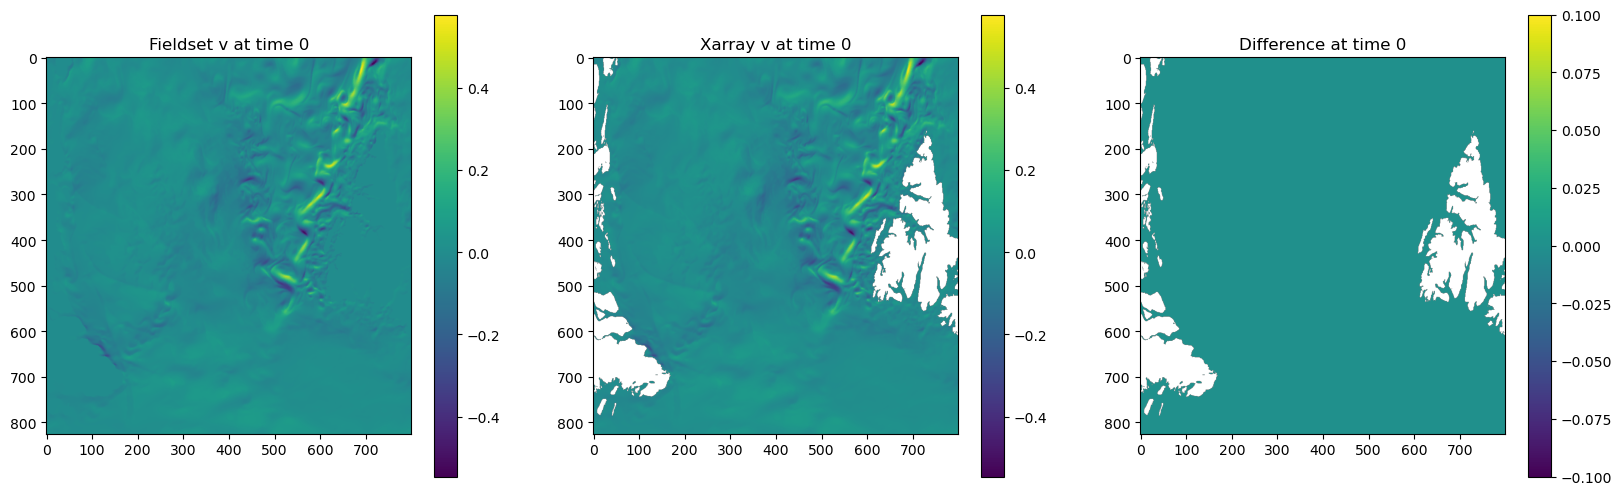

In [28]:
var = "v"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
im1 = ax1.imshow(fieldset.V.data[0,:,:])
plt.colorbar(im1, ax=ax1)
ax1.set_title(f"Fieldset {var} at time 0")

im2 = ax2.imshow(ds_model[var].isel(time=0).values.squeeze())
plt.colorbar(im2, ax=ax2)
ax2.set_title(f"Xarray {var} at time 0")

# plot difference
diff = fieldset.V.data[0,:,:] - ds_model[var].isel(time=0).values.squeeze()
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title("Difference at time 0")

### Write Kernels

In [29]:
def SampleTS(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]
    #particle.temperature = fieldset.T[time, particle.lat, particle.lon]
    #particle.salinity = fieldset.S[time, particle.lat, particle.lon]
    #particle.vorticity = fieldset.vorticity[time, particle.depth, particle.lat, particle.lon]

def SampleVelocity(particle, fieldset, time):
    # calculate velocity magnitude from u and v
    #
    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    v = fieldset.V[time, particle.depth, particle.lat, particle.lon]
    #u = fieldset.U[time, particle.lat, particle.lon]
    #v = fieldset.V[time, particle.lat, particle.lon]
    # u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    particle.u = u
    particle.v = v
    particle.velocity = (u**2 + v**2)**0.5

## Compute trajectories

In [58]:
ds_model

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-12-31T23:57:30 ... 2002-12-30T23:...
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, lat, lon) float64 2GB ...
    salt     (time, lat, lon) float64 2GB ...
    u        (time, lat, lon) float64 2GB ...
    v        (time, lat, lon) float64 2GB ...

In [30]:
pset.execute(
    [AdvectionRK4, SampleTS, SampleVelocity],
    runtime=timedelta(days=20),  #100           
    dt=timedelta(minutes=15),              
    output_file=pset.ParticleFile(name=outfname, outputdt=timedelta(hours=12)) #hours=12
)

/albedo/home/quraus001/miniforge3/envs/parcels/lib/python3.13/site-packages/parcels/field.py:1180: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in surface-test_data_gradient.zarr.
100%|██████████| 1728000.0/1728000.0 [00:13<00:00, 127361.11it/s]


In [31]:
# function to convert .zarr to netcdf without dask array chunks
import xarray as xr
import shutil

def zarr_to_netcdf(zarr_file, netcdf_file, delete=False):
    """
    Convert a Zarr file to NetCDF format using xarray.
    Args:
        zarr_file (str): Path to the input Zarr file.
        netcdf_file (str): Path to the output NetCDF file.
        delete (bool): If True, delete the original Zarr file after conversion.
    """

    # Open the Zarr file
    ds = xr.open_zarr(zarr_file, consolidated=True)

    # Convert to NetCDF
    ds.to_netcdf(netcdf_file)

    # Close the dataset
    ds.close()
    # Optionally delete the original Zarr file
    if delete:
        
        shutil.rmtree(zarr_file)
        print(f"Deleted Zarr file: {zarr_file}")

In [32]:
try:
    ds.close()
except:
    print("ds.close() failed, but that's okay. It might be already closed.")
#outfname = "output_debug_velocities_spherical"
zarr_to_netcdf(outfname + ".zarr", outfname + ".nc", delete=True)

ds.close() failed, but that's okay. It might be already closed.
Deleted Zarr file: surface-test_data_gradient.zarr


## Look at data

In [33]:
ds = xr.open_dataset(outfname + ".nc")
ds#.lon.isel(trajectory=5).plot(x = "obs")

<xarray.Dataset> Size: 16kB
Dimensions:      (trajectory: 10, obs: 40)
Coordinates:
  * obs          (obs) int32 160B 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * trajectory   (trajectory) int64 80B 20 21 22 23 24 25 26 27 28 29
Data variables:
    lat          (trajectory, obs) float32 2kB ...
    lon          (trajectory, obs) float32 2kB ...
    salinity     (trajectory, obs) float32 2kB ...
    temperature  (trajectory, obs) float32 2kB ...
    time         (trajectory, obs) object 3kB ...
    u            (trajectory, obs) float32 2kB ...
    v            (trajectory, obs) float32 2kB ...
    velocity     (trajectory, obs) float32 2kB ...
    z            (trajectory, obs) float32 2kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4SampleTSSampleVelocity
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [34]:

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points on the Earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [35]:
import pandas as pd

In [42]:
pd.to_datetime(ds.time.values[0,0].strftime("%Y-%m-%d %H:%M:%S"))

Timestamp('2002-01-01 23:57:30')

In [45]:
ds.time.isel(trajectory=trajectory, obs=0).values.item()

cftime.DatetimeNoLeap(2002, 1, 1, 23, 57, 30, 0, has_year_zero=True)

In [47]:
pd.to_datetime(ds.time.isel(trajectory=trajectory, obs=0).values.item().strftime("%Y-%m-%d %H:%M:%S"))

Timestamp('2002-01-01 23:57:30')

In [61]:
trajectory = 9  # first trajectory

num_obs = 20

# calculate the distance between first and 5th observation of the first trajectory
lon1 = ds.lon.isel(trajectory=trajectory, obs=0).values.item()
lat1 = ds.lat.isel(trajectory=trajectory, obs=0).values.item()
lon2 = ds.lon.isel(trajectory=trajectory, obs=num_obs-1).values.item()
lat2 = ds.lat.isel(trajectory=trajectory, obs=num_obs-1).values.item()
distance = haversine(lon1, lat1, lon2, lat2)
print(f"Distance between first and 5th observation of the first trajectory: {distance:.2f} km")

# Calculate the speed of the particle between the first and 5th observation in m/s
try:
    t1 = pd.to_datetime(ds.time.isel(trajectory=trajectory, obs=0).values)
    t2 = pd.to_datetime(ds.time.isel(trajectory=trajectory, obs=num_obs-1).values)
except:
    t1 = pd.to_datetime(ds.time.isel(trajectory=trajectory, obs=0).values.item().strftime("%Y-%m-%d %H:%M:%S"))
    t2 = pd.to_datetime(ds.time.isel(trajectory=trajectory, obs=num_obs-1).values.item().strftime("%Y-%m-%d %H:%M:%S"))
time_diff = t2 - t1
time_diff_seconds = time_diff.total_seconds()
print(f"Time difference: {time_diff_seconds:.0f} seconds OR {time_diff_seconds/3600:.0f} hours")
speed = distance * 1000 / time_diff_seconds  # convert km to m
print(f"Speed of the particle between first and 5th observation: {speed:.2f} m/s")

# compare to model data
ds_model = xr.open_dataset(inpath + file)
# Get velocities at the obs 0:4 by searching for nearest lon/lat
AVG_vel = []
for obs in range(num_obs):
    lon = ds.lon.isel(trajectory=trajectory, obs=obs).values.item()
    lat = ds.lat.isel(trajectory=trajectory, obs=obs).values.item()
    time = ds.time.isel(trajectory=trajectory, obs=obs).values.item()  # Get the time of the observation
    u_model = ds_model.u.sel(lon=lon, lat=lat, time=time, method="nearest").values.item()
    v_model = ds_model.v.sel(lon=lon, lat=lat, time=time, method="nearest").values.item()
    #print(f"Model U at obs {obs}: {u_model:.4f}, V at obs {obs}: {v_model:.4f}")
    model_speed = (u_model**2 + v_model**2)**0.5
    #print(f"Model speed at obs {obs}: {model_speed:.4f} m/s")
    AVG_vel.append(model_speed)
# Calculate the average model speed over the first 5 observations
avg_model_speed = np.mean(AVG_vel)
print(f"Average model speed over near the 5 observations: {avg_model_speed:.4f} m/s")


Distance between first and 5th observation of the first trajectory: 31.35 km
Time difference: 820800 seconds OR 228 hours
Speed of the particle between first and 5th observation: 0.04 m/s
Average model speed over near the 5 observations: 0.0524 m/s


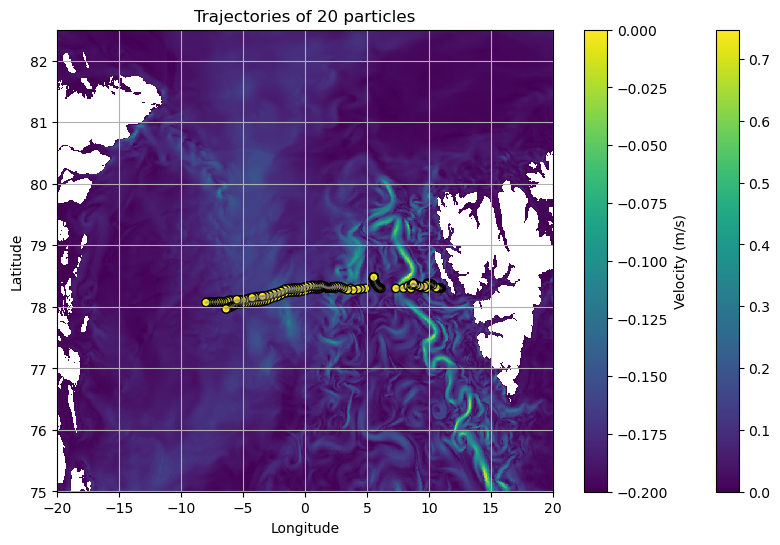

In [60]:
#ds = xr.open_zarr(outfile)

vmin, vmax = -2, 5
var1 = "temp"
var2 = "temperature"

var1, var2 = "u", "u"
vmin, vmax = -0.2, 0

plt.figure(figsize=(10,6))
#ds_model[var1].isel(time=0).plot(cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)

# calculate and plot model absolute velocity
velocity = (ds_model.u.isel(time=0)**2 + ds_model.v.isel(time=0)**2)**0.5
velocity.plot(cmap="viridis")#, vmin=vmin, vmax=vmax, add_colorbar=False)

for pid in ds.trajectory[:]:
    plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Particle {pid.values}", color="grey", alpha=0.5)
    plt.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds[var2].sel(trajectory=pid), cmap="viridis", vmin=vmin, vmax=vmax, edgecolor="black") # 0,5 , vmin=-3.5, vmax=6
plt.colorbar(label="Velocity (m/s)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectories of 20 particles")
#plt.legend()
plt.grid(True)
plt.show()

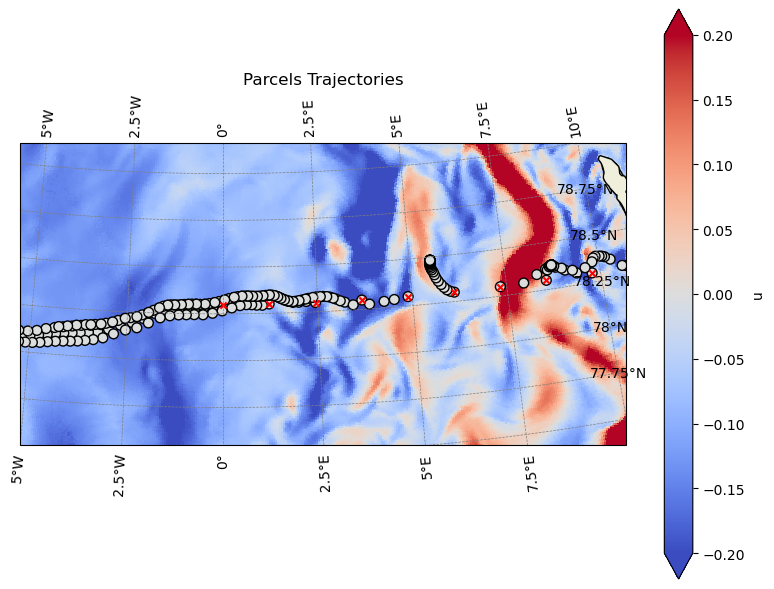

In [12]:
#vmin, vmax = -0.6, 0.6
vmin, vmax = -0.2, 0.2
#vmin, vmax = -1,5

var1 = "temp"
var2 = "temperature"

var1, var2 = "u", "u"


fig = plt.figure(figsize=(8, 6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)


# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
#ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())
ax.set_extent([-5, 10, 77.5, 79], crs=ccrs.PlateCarree())
#ax.set_extent([0, 11, 77.5, 81], crs=ccrs.PlateCarree())

ds_model[var1].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=True)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid in ds.trajectory:
    steps = 1
    ax.scatter(ds.lon.sel(trajectory=pid)[::steps], ds.lat.sel(trajectory=pid)[::steps], c=ds[var2].sel(trajectory=pid)[::steps], cmap="coolwarm", alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6
    #ax.scatter(ds.lon.sel(trajectory=pid)[0], ds.lat.sel(trajectory=pid)[0], c=ds[var2].sel(trajectory=pid)[0], cmap="coolwarm", alpha=1, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black', s=50) # 0,5 , vmin=-3.5, vmax=6
    
if True:
    ax.scatter(
    ds.lon.isel(obs=0),
    ds.lat.isel(obs=0),
    color='red',
    s=20,
    transform=ccrs.PlateCarree(),
    label="Start",
    marker="x"
)

plt.title("Parcels Trajectories")
#plt.legend()
plt.tight_layout()
plt.show()

In [93]:
ds.close()

## Plot Map with ETOPO Background

In [ ]:
# Load ETOPO1
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)      
)

In [18]:
def get_colormap_colors(colormap='plasma', num_colors=20):
    # Create a linear space of values from 0 to 1
    values = np.linspace(0, 1, num_colors)
    
    # Get the colormap from matplotlib or try from cmocean
    try:
        cmap = plt.get_cmap(colormap)
    except ValueError:
        # If the colormap is not found, use cmocean
        cmap = getattr(cmo.cm, colormap)

    
    # Get the colors corresponding to the values
    colors = [cmap(val) for val in values]
    
    return colors

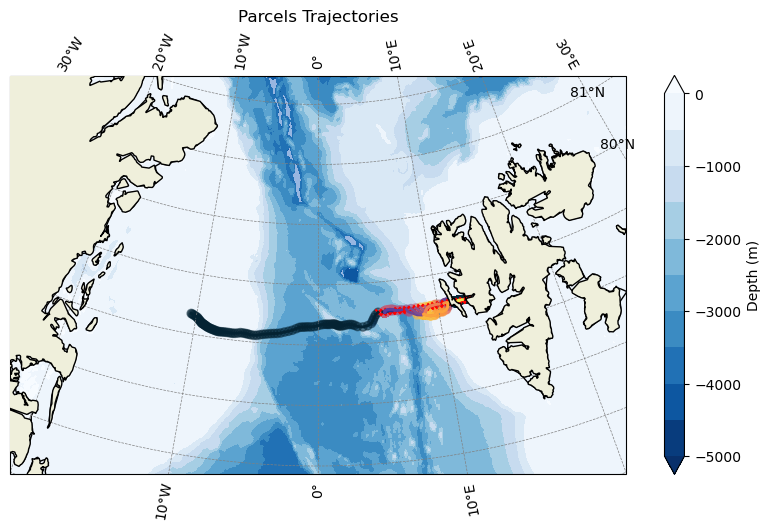

In [11]:
colors = get_colormap_colors(colormap='thermal', num_colors=20)

fig = plt.figure(figsize=(8, 6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)

# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())

# Plot the bathymetry
bathy_data = ds_fram_bath['z']
lon = ds_fram_bath['lon']
lat = ds_fram_bath['lat']

# Contourf or pcolormesh for bathymetry
cs = ax.contourf(
    lon, lat, bathy_data,
    levels=np.arange(-5000, 500, 500),
    cmap="Blues_r",
    extend='both',
    transform=ccrs.PlateCarree()
)

plt.colorbar(cs, ax=ax, orientation='vertical', label='Depth (m)', shrink=0.7)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid, color in zip(ds.trajectory, colors):
    ax.plot(
        ds.lon.sel(trajectory=pid),
        ds.lat.sel(trajectory=pid),
        transform=ccrs.PlateCarree(),
        label=f"Particle {pid.values}",
        linewidth=2,
        color=color,
    )
    ax.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds.temperature.sel(trajectory=pid), cmap=cmo.cm.thermal, alpha=0.5, vmin=0, vmax=5, transform=ccrs.PlateCarree())


# Optional: mark starting locations
ax.scatter(
    ds.lon.isel(obs=0),
    ds.lat.isel(obs=0),
    color='red',
    s=20,
    transform=ccrs.PlateCarree(),
    label="Start",
    marker="x"
)

plt.title("Parcels Trajectories")
#plt.legend()
plt.tight_layout()
plt.show()